In [1]:
# Standard Library
import ast
import multiprocessing as mp
import os
import random
import shutil
from collections import Counter, defaultdict
from typing import List, Tuple

# Data Processing
import numpy as np
import pandas as pd
import polars as pl

# Medical Imaging
import pydicom as dicom

# Visualization
import matplotlib.pyplot as plt

# SciPy / Image Processing
import scipy.ndimage as ndi
from scipy import ndimage
from scipy.ndimage import (zoom as ndi_zoom, binary_dilation, binary_closing, generate_binary_structure,)

# ML / Preprocessing
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit,)
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# Kaggle Evaluation Tools
import kaggle_evaluation.rsna_inference_server

In [2]:
ID_COL = 'SeriesInstanceUID'

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

DICOM_TAG_ALLOWLIST = [
    'BitsAllocated',
    'BitsStored',
    'Columns',
    'FrameOfReferenceUID',
    'HighBit',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'Modality',
    'PatientID',
    'PhotometricInterpretation',
    'PixelRepresentation',
    'PixelSpacing',
    'PlanarConfiguration',
    'RescaleIntercept',
    'RescaleSlope',
    'RescaleType',
    'Rows',
    'SOPClassUID',
    'SOPInstanceUID',
    'SamplesPerPixel',
    'SliceThickness',
    'SpacingBetweenSlices',
    'StudyInstanceUID',
    'TransferSyntaxUID',
]

In [3]:
# Model configuration
TARGET_SIZE = (160, 160, 160)  # Reduced size for memory efficiency
TARGET_ISO_BRAIN = 1.25
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Pre-Processing:

## Helper Functions

In [4]:
def _get_slice_order(slice_sample):
    """
    INPUT: 
    slice_sample: dicom read single slice.
    OUPTUT:
    z_cord: slice's Z axis index for ordering.
    """
    #check if the slice/dicom_file has ImageOrientationPatient
    iop = getattr(slice_sample, "ImageOrientationPatient", None)
    ipp = getattr(slice_sample, "ImagePositionPatient", None)

    if iop is not None and ipp is not None and len(iop)>=6 and len(ipp)>=3:
        x_cord = np.array(iop[:3], float)      # rows dir (x)
        y_cord = np.array(iop[3:6], float)     # cols dir (y)
        z_cord = np.cross(x_cord, y_cord)      # slice normal (z)
        ipp = np.array(ipp[:3], float)
        return float(np.dot(ipp, z_cord))

    ins_num = getattr(slice_sample, "InstanceNumber", None)
    if ins_num is not None:
        z_cord = int(ins_num)
        return z_cord 

def _slice_by_slice_correct_rescale(list_of_slices):
    """
    INPUT: 
    list_of_slices: List of dicom read slices (order does not matter).
    OUPTUT:
    corrected_slices: 1 channel, propper gray scale and corrected list of dicom slices in Array form.
    """
    corrected_slices = []
    for slce in list_of_slices:
        slce_array = slce.pixel_array.astype(np.float32)
        
        #Fix the contrast of some images in case the smaller values are white instead of black for consistency
        # https://dicom.innolitics.com/ciods/rt-dose/image-pixel/00280004
        # https://dgobbi.github.io/vtk-dicom/doc/api/imageDisplay.html?utm_source=chatgpt.com
        phot = str(getattr(slce, "PhotometricInterpretation", "MONOCHROME2")).upper()
        if phot == "MONOCHROME1":
            maxv = (2**int(getattr(slce, "BitsStored", arr.dtype.itemsize*8))) - 1
            slce_array = maxv - slce_array

        # https://collectiveminds.health/articles/the-ultimate-guide-to-preprocessing-medical-images-techniques-tools-and-best-practices-for-enhanced-diagnosis
        #Collapse channels if there are more than 1, maybe just CT, but lets be sure.
        spp = int(getattr(slce, "SamplesPerPixel", 1))
        if spp == 3 and slce_array.ndim == 3:
            slce_array = slce_array.mean(axis=-1)
        
        # Apply DICOM linear HU rescale because we are using different modalities: https://www.mathworks.com/help/medical-imaging/ug/overview-medical-image-preprocessing.html 
        slope = float(getattr(slce, "RescaleSlope", 1.0))
        inter = float(getattr(slce, "RescaleIntercept", 0.0))
        corrected_slices.append(slce_array * slope + inter)
    return corrected_slices

def _get_slices_spacing(list_of_slices):
    """
    INPUT: 
    list_of_slices: List of dicom read slices (order does not matter).
    OUPTUT:
    spacing_zyx: the pixel spacing from the dicom files in Array form
    """
    sy, sx = map(float, getattr(list_of_slices[0], "PixelSpacing", [1.0,1.0]))
    sz = None

    st = getattr(list_of_slices[0], "SliceThickness", None)
    sbs = getattr(list_of_slices[0], "SpacingBetweenSlices", None)
    if st is not None:
        sz = float(st)
    if sbs is not None:
        sz = float(sbs)

    if sz is None:
        iop = getattr(list_of_slices[0], "ImageOrientationPatient", None)
        if iop is not None and len(iop) >= 6:
            row = np.array(iop[:3], dtype=float)
            col = np.array(iop[3:6], dtype=float)
            norm   = np.cross(row, col)
            scalars = []
            for slc in list_of_slices:
                ipp = getattr(slc, "ImagePositionPatient", None)
                if ipp is not None and len(ipp)>=3:
                    scalars.append(np.dot(np.array(ipp[:3], float), norm))
            if len(scalars)>=2:
                diffs = np.diff(np.sort(scalars))
                sz = float(np.median(np.abs(diffs)))
        if sz is None:
            sz = 1.0
    spacing_zyx = (sz, sy, sx)
    return spacing_zyx

def load_dicom_series(dicom_patient_dir):
    """
    INPUT: 
    dicom_patient_dir: Patient folder directory with dicom files per slice.
    OUPTUT:
    dicom_vol: Ordered and rescaled read dicom slices stacked to make a volume
    modality: MRI, CTA, etc....

    Variables Cheat Sheet
    list_slices_files: The list of PATHS for each slice in the patient folder.
    dicom_slices: dicom read files with data.
    """
    list_slices_files = [
        os.path.join(dicom_patient_dir, f) 
        for f in os.listdir(dicom_patient_dir) 
        if f.lower().endswith(".dcm")]
    
    if not list_slices_files: 
        raise ValueError(f"No DICOM slice files found in patient folder: {dicom_patient_dir}.")
    
    dicom_slices = []
    for slice_file in list_slices_files:
        dicom_slice = dicom.dcmread(
            slice_file, stop_before_pixels=False, force=True)
        dicom_slices.append(dicom_slice)

    dicom_slices.sort(key=_get_slice_order)
    modality = getattr(dicom_slices[0], 'Modality')
    the_series_uid = getattr(dicom_slices[0], "SeriesInstanceUID")

    # Calculate the Spacing using the dicom metadata of one slice.
    spacing_zyx = _get_slices_spacing(dicom_slices)

    
    slices = _slice_by_slice_correct_rescale(dicom_slices)
    dicom_vol = np.stack(slices, axis=0)

    return modality, spacing_zyx, dicom_vol, the_series_uid, dicom_slices



def resample_isotropic(vol_zyx, spacing_zyx, target_iso=1, order=1):
    """
    Resample a [Z,H,W] volume to isotropic spacing (target_iso in mm).
    INPUT:
      vol_zyx: np.ndarray [Z,H,W]
      spacing_zyx: tuple (sz, sy, sx) in mm
      target_iso: desired isotropic spacing in mm 
      order: interpolation order (1 = linear)
    OUPTUT:
      vol_iso: np.ndarray resampled volume
      new_spacing_zyx: (target_iso, target_iso, target_iso)
    """
    sz, sy, sx = map(float, spacing_zyx)
    tz = ty = tx = float(target_iso)

    # zoom factors are (old_spacing / new_spacing)
    zoom_factors = (sz / tz, sy / ty, sx / tx)
    vol_iso = ndi_zoom(vol_zyx, zoom=zoom_factors, order=order)
    spacing_iso_zyx = (tz, ty, tx)
    return spacing_iso_zyx, vol_iso.astype(np.float32)

def modality_specific_preprocessing(vol, modality, cta_startegy="clip"):
    """
    Clip the extremes values of a volume (HU scaled)
    INPUT:
        volume: full sampled volume
    OUPTUT: 
        volume: extremes clipped volume
    Variables Cheat Sheet:
        cta_startegy: clip or hu_window
    """
    if modality == 'CTA' or modality == 'CT':
        if cta_startegy == 'clip':
            vol = _clip_by_percentile_per_volume(vol)
        elif cta_startegy == 'hu_window':
            vol = _apply_hu_window(vol)
        elif cta_startegy == 'hu_range':
            vol = _apply_hu_range(vol)
        else:
            vol = _clip_by_percentile_per_volume(vol)
        
        vol = _apply_normalization(vol, norm='min-max')
        return vol
    else:
        vol = _apply_normalization(vol, norm='z-score')
        return vol

def _clip_by_percentile_per_volume(vol, low_p=0.5, high_p=99.5):
    """
    Clip the HU value of the CT volume
    INPUT: 
        vol: volume tensor
        low: lower percentile value to clip
        high: higher percentile value to clip
    
    OUPTUT:
        vol: clipped vol
    """
    lo = np.percentile(vol, low_p)
    hi = np.percentile(vol, high_p)
    vol = np.clip(vol, lo, hi)
    return ((vol - lo) / (hi - lo + 1e-6)).astype(np.float32)

def _apply_hu_window(vol, center=125, width=550):
    """
    INPUT: 
        vol: volume tensor
        center: center of the HU window
        width: width of the HU unit window [center-width, center+width]
    
    OUPTUT:
        vol: volume scaled to the defined window.
    """
    lo = center - width/2.0
    hi = center + width/2.0
    vol = np.clip(vol, lo, hi)
    return ((vol - lo) / (hi - lo + 1e-6)).astype(np.float32)

def _apply_hu_range(vol, hounsfield_range=(100, 600)):
    """
    INPUT: 
        vol: volume tensor
        center: center of the HU window
        width: width of the HU unit window [center-width, center+width]
    
    OUPTUT:
        range_vol: a mask of only the boders
    """
    mask = (vol >= hounsfield_range[0]) & (vol <= hounsfield_range[1])
    range_vol = np.where(mask, vol, 0)
    return range_vol

def _apply_normalization(vol, norm='z-score'):
    """
    INPUT: 
        vol: volume tenso
        norm: normalization strategy (max-min for CTA, z-score for MRI)
    
    OUPTUT:
        vol: Normalized volume tensor.
    """
    if norm == 'min-max':
        return (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)
    elif norm == 'z-score':
        return (vol - vol.mean()) / vol.std()

def center_crop_or_pad(vol, target_shape, z_start=0.55, x_start=0.5, y_start=0.5):
    vol_z, vol_y, vol_x = vol.shape
    tz, ty, tx = target_shape
    padz = max(tz - vol_z, 0)
    pady = max(ty - vol_y, 0)
    padx = max(tx - vol_x, 0)
    vol = np.pad(vol,
                 ((padz//2, padz - padz//2),
                  (pady//2, pady - pady//2),
                  (padx//2, padx - padx//2)),
                 mode='constant')
    z, y, x = vol.shape
    cz = int(round(z_start * (z - 1)))
    cy = int(round(y_start * (y - 1)))
    cx = int(round(x_start * (x - 1)))
    
    startz, starty, startx = cz-tz//2, cy-ty//2, cx-tx//2
    startz = max(0, min(z - tz, startz))
    starty = max(0, min(y - ty, starty))
    startx = max(0, min(x - tx, startx))
                       
    endz, endy, endx = startz + tz, starty + ty, startx + tx
    return vol[startz:endz, starty:endy, startx:endx]

## Main Function

In [5]:
def load_and_preprocess_series(dicom_dir):
    """
    Full pipeline:
    DICOM folder -> ordered + HU-rescaled slices -> 
    modality-specific normalization -> isotropic resample -> center crop/pad.
    Returns:
        vol_iso: np.ndarray [Z,H,W] float32 normalized, ready for U-Net.
        modality: modality string ("CT", "CTA", "MR", ...)
        spacing_iso_zyx: (1,1,1) after resample (for reference only)
    """
    # 1) Load dicom series
    modality, spacing_zyx_raw, sample_volume_raw, series_uid, dicom_slices = load_dicom_series(dicom_dir)

    # 2) Modality-specific preprocessing (HU window/clip + normalization)
    sample_volume_pre = modality_specific_preprocessing(sample_volume_raw, modality, cta_startegy="hu_window")

    # Handle unnecessary frame dim if present
    if sample_volume_pre.ndim == 4 and sample_volume_pre.shape[0] == 1:
        sample_volume_pre = np.squeeze(sample_volume_pre, axis=0)

    # 3) Resample to isotropic spacing
    spacing_zyx_iso, volume_iso = resample_isotropic(sample_volume_pre, spacing_zyx_raw, target_iso=TARGET_ISO_BRAIN)

    # 4) Center crop or pad to fixed shape
    volume_iso = center_crop_or_pad(volume_iso, TARGET_SIZE).astype(np.float32)

    return volume_iso, modality, spacing_zyx_iso

# Models Used

## U-Net

In [6]:
class ConvBlock3D(nn.Module):
    """
    3D convolutional downsampling block:
    Based on: 
    github.com/ahsan-83/Deep-Learning-Specialization-Coursera/blob/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/Image_segmentation_Unet_v2.ipynb
    Tweaked for 3D
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
      next_layer, skip_connection --  Next layer and skip connection outputs
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.0, use_maxpool=True):
        super().__init__()
        self.use_maxpool = use_maxpool

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.dropout = nn.Dropout3d(dropout_prob) if dropout_prob > 0 else None
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2) if use_maxpool else None

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        if self.dropout is not None:
            x = self.dropout(x)
            
        if self.use_maxpool:
            next_layer = self.pool(x)
        else:
            next_layer = x

        skip = x  # skip connection

        return next_layer, skip


In [7]:
class UpBlock3D(nn.Module):
    """
    Convolutional upsampling block
    Based on: 
    github.com/ahsan-83/Deep-Learning-Specialization-Coursera/blob/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/Image_segmentation_Unet_v2.ipynb
    Tweaked for 3D
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # upsample by factor 2 in D, H, W
        self.upconv = nn.ConvTranspose3d(
            in_channels, out_channels,
            kernel_size=2, stride=2
        )

        # Merge the previous output and the contractive_input
        self.conv1 = nn.Conv3d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, expansive_input, contractive_input):
        x = self.upconv(expansive_input)
        x = torch.cat([contractive_input, x], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        return x

In [8]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, n_filters=16, n_classes=1):
        """
        in_channels: channels of input volume (e.g., 1 for CT/MRI)
        n_filters: base number of filters (you may want 16 or 32 depending on GPU)
        n_classes: output channels (1 for binary mask)
        """
        super().__init__()

        # Encoder: Down
        self.enc1 = ConvBlock3D(in_channels,      n_filters,      dropout_prob=0.0, use_maxpool=True)
        self.enc2 = ConvBlock3D(n_filters,        n_filters * 2,  dropout_prob=0.0, use_maxpool=True)
        self.enc3 = ConvBlock3D(n_filters * 2,    n_filters * 4,  dropout_prob=0.0, use_maxpool=True)
        self.enc4 = ConvBlock3D(n_filters * 4,    n_filters * 8,  dropout_prob=0.0, use_maxpool=True)
        self.bottleneck = ConvBlock3D(n_filters * 8, n_filters * 16,
                                      dropout_prob=0.0, use_maxpool=False)

        # Decoder: Up
        self.up4 = UpBlock3D(n_filters * 16, n_filters * 8)  
        self.up3 = UpBlock3D(n_filters * 8,  n_filters * 4)   
        self.up2 = UpBlock3D(n_filters * 4,  n_filters * 2)   
        self.up1 = UpBlock3D(n_filters * 2,  n_filters * 1)   
        self.final_conv = nn.Conv3d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):

        # Encoding
        x1, skip1 = self.enc1(x)
        x2, skip2 = self.enc2(x1)
        x3, skip3 = self.enc3(x2)
        x4, skip4 = self.enc4(x3)

        # Bottleneck
        bottleneck, _ = self.bottleneck(x4)

        # Decoding
        d4 = self.up4(bottleneck, skip4)
        d3 = self.up3(d4,        skip3)
        d2 = self.up2(d3,        skip2)
        d1 = self.up1(d2,        skip1)

        logits = self.final_conv(d1)
        return logits
    


In [9]:
def build_roi_from_pred_mask(vol_tensor, mask_logits, padding=5, size=(64,64,64)):
    Dz, Dy, Dx = size
    
    #Make binay mask
    probs = torch.sigmoid(mask_logits)
    mask  = (probs > 0.5).float()

    B, C, D, H, W = vol_tensor.shape

    #Get the center depending the case
    #Center crop if no mask was predicted, to work around false positives returned by U-Net
    if mask.sum() == 0:
        cz, cy, cx = D//2, H//2, W//2
    else:
        coords = mask.nonzero(as_tuple=False).float()   
        cz, cy, cx = coords[:, 2:].mean(dim=0).tolist() 
        cz, cy, cx = int(cz), int(cy), int(cx)

    #get ROI coordinates
    z_min = max(0, cz - Dz // 2)
    y_min = max(0, cy - Dy // 2)
    x_min = max(0, cx - Dx // 2)

    z_max = min(D, z_min + Dz)
    y_max = min(H, y_min + Dy)
    x_max = min(W, x_min + Dx)

    #get ROI
    roi = vol_tensor[:, :, z_min:z_max, y_min:y_max, x_min:x_max]
    return roi, (cz, cy, cx)

## Classification Head

In [10]:
class AneurysmClassifier3D(nn.Module):
    def __init__(self, in_channels=1, num_classes=16):
        super().__init__()
        
        # Conv3D -> BN -> ReLU -> MaxPool
        self.features = nn.Sequential(
            self._conv_block(in_channels, 16),
            nn.MaxPool3d(2), # 64 -> 32
            
            self._conv_block(16, 32),
            nn.MaxPool3d(2), # 32 -> 16
            
            self._conv_block(32, 64),
            nn.MaxPool3d(2), # 16 -> 8
            
            self._conv_block(64, 128),
            nn.MaxPool3d(2), # 8 -> 4
        )
        
        # Classification
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), # Flattens [128, 4, 4, 4] -> [128, 1, 1, 1]
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Loading Models

In [11]:
def load_models():
    
    global UNET, CLS
    UNET = UNet3D(in_channels=1, n_filters=8, n_classes=1).to(DEVICE)
    UNET.load_state_dict(torch.load("/kaggle/input/unet-bce-and-dice-loss-checkpoint-7epochs/pytorch/default/1/epoch6_unet3d_seg (3).pth", map_location=DEVICE))
    UNET.eval()

    CLS = AneurysmClassifier3D(num_classes=len(LABEL_COLS)).to(DEVICE)
    CLS.load_state_dict(torch.load("/kaggle/input/roi-classifier-3d-cnn/tensorflow2/default/5/aneurysm_roi_classifier_simple.pth", map_location=DEVICE))
    CLS.eval()
    return UNET, CLS

# Predict

In [12]:
def predict(series_path: str, slice_to_view = None):

    #Get the Whole path to a user's folder with dicom files.
    series_id = os.path.basename(series_path)
    #Preprocess the Volume of the user based only on the DICOM files in their folder
    vol_iso, modality, spacing_iso = load_and_preprocess_series(series_path)

    #Get the volume: FOR VISUALIZATION ONLY
    vol_t = torch.from_numpy(vol_iso).unsqueeze(0).unsqueeze(0).to(DEVICE)
    plt.figure(figsize=(20,4))
    print(vol_t.shape)
    
    #Load Both Models
    unet, cls = load_models()
    
    with torch.no_grad():
        #Get the predicted logits of the mask using the volume as input for the U-Net
        mask_logits = unet(vol_t)  # [1, 1, D, H, W]
        probs = torch.sigmoid(mask_logits)

        #Get the mask and reduze single dimensions. FOR VISUALIZATION ONLY
        mask  = (probs > 0.5).float() 
        probs_2d_max = probs.max(dim=4)[0].max(dim=3)[0]  
        probs_1d = probs_2d_max.squeeze(0).squeeze(0)  
        mask_slices = (probs_1d > 0.01).nonzero(as_tuple=True)[0] 
        print("U-Net's predicted mask shape:", mask_logits.shape)
        print("U-Net's mask's slices containing pixels:", mask_slices.tolist())
        print("Number of slices with positive pixels:", len(mask_slices))
        
        # Build ROI using the U-Net's generated Mask's centroid
        roi, centroid = build_roi_from_pred_mask(vol_t, 
                                       mask_logits, 
                                       padding=5, 
                                       size=(64, 64, 64))

        # VISUALZIE THE OBTAINED MASK, and ROI
        plt.subplot(1,4,1)
        plt.imshow(vol_t[0, 0, centroid[0]].numpy())
        plt.scatter([centroid[2]], [centroid[1]], c='red', s=40)
        plt.title("Original Volume")
        print("Visualizing slice with mask' center. Slice No.:", centroid[2])
        plt.subplot(1,4,2)
        plt.imshow(mask_logits[0, 0, centroid[0]].numpy())
        plt.scatter([centroid[2]], [centroid[1]], c='red', s=40)
        plt.title("U-net's probs")
        plt.subplot(1,4,3)
        plt.imshow(mask[0, 0, centroid[0]].numpy())
        plt.scatter([centroid[2]], [centroid[1]], c='red', s=40)
        plt.title(f"U-net's binary mask with center: {centroid}")
        plt.subplot(1,4,4)
        plt.imshow(roi[0, 0, 32].numpy())
        plt.title(f"Center of the generated ROI")

        # Classify ROI
        logits = cls(roi)[0]  # [num_labels]
        probs_t = torch.sigmoid(logits)
        probs = probs_t.detach().cpu().numpy().astype(np.float32)
    
    predictions = pd.DataFrame([[series_id, *probs]], columns=[ID_COL, *LABEL_COLS])
    return predictions.drop(columns=[ID_COL])
   

# Visualize Samples of Confirmed Aneurysms

In [13]:
localizer_csv = "/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv"
df = pd.read_csv(localizer_csv)

## False Negative

SeriesInstanceUID    1.2.826.0.1.3680043.8.498.10058383541003792190...
SOPInstanceUID       1.2.826.0.1.3680043.8.498.31431259232149492723...
coordinates          {'x': 204.85273492286117, 'y': 234.9957924263675}
location                                  Right Middle Cerebral Artery
Name: 10, dtype: object
torch.Size([1, 1, 160, 160, 160])
U-Net's predicted mask shape: torch.Size([1, 1, 160, 160, 160])
U-Net's mask's slices containing pixels: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
Number of slices with positive pixels: 66
Visualizing slice with mask' center. Slice No.: 80


,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,0.221456,0.259175,0.441965,0.44435,0.372042,0.395014,0.386316,0.133143,0.131299,0.178955,0.186699,0.221512,0.263979,0.474181


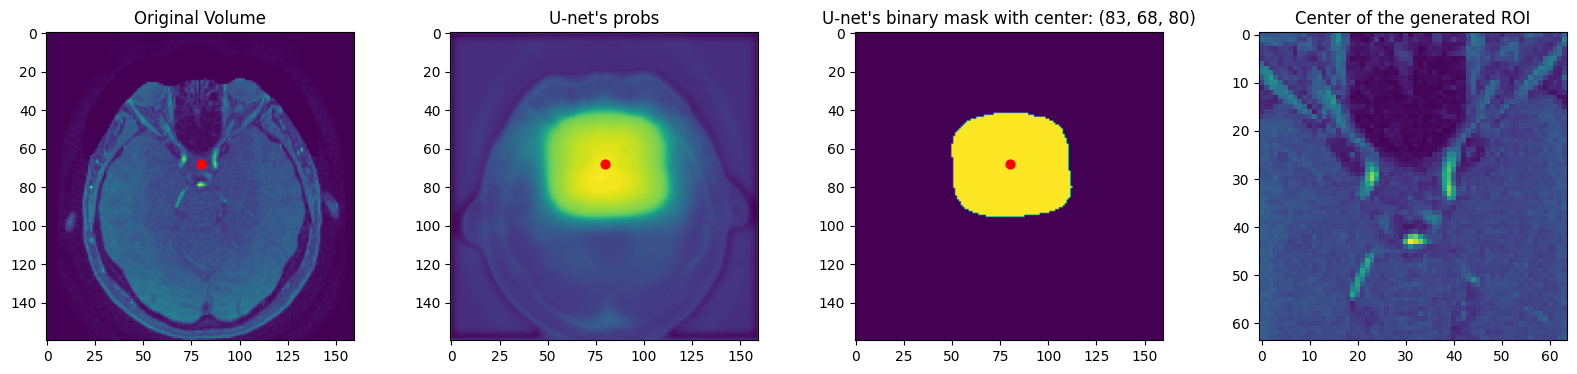

In [14]:
SERIES_EXAMPLE_NUMBER = df['SeriesInstanceUID'].iloc[10]
print(df.iloc[10])
SERIES_EXAMPLE = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
SERIES_EXAMPLE_FULL = SERIES_EXAMPLE + SERIES_EXAMPLE_NUMBER
predictions = predict(series_path= SERIES_EXAMPLE_FULL, slice_to_view=84)
predictions

# True Positive

SeriesInstanceUID    1.2.826.0.1.3680043.8.498.10097649530131165889...
SOPInstanceUID       1.2.826.0.1.3680043.8.498.56762390394513915690...
coordinates           {'x': 325.6890524379025, 'y': 251.5252989880405}
location                                 Anterior Communicating Artery
Name: 15, dtype: object
torch.Size([1, 1, 160, 160, 160])
U-Net's predicted mask shape: torch.Size([1, 1, 160, 160, 160])
U-Net's mask's slices containing pixels: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
Number of slices with positive pixels: 68
Visualizing slice with mask' center. Slice No.: 76


,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,0.264012,0.326734,0.537276,0.52062,0.381326,0.44361,0.398697,0.124867,0.122553,0.169567,0.170295,0.206815,0.274791,0.547612


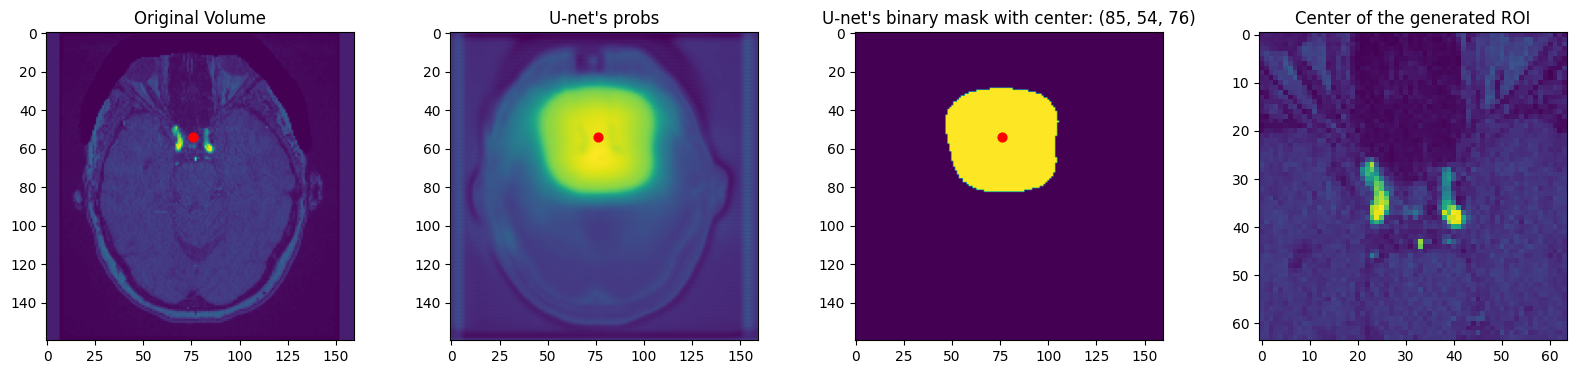

In [15]:
SERIES_EXAMPLE_NUMBER = df['SeriesInstanceUID'].iloc[15]
print(df.iloc[15])
SERIES_EXAMPLE = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
SERIES_EXAMPLE_FULL = SERIES_EXAMPLE + SERIES_EXAMPLE_NUMBER
predictions = predict(series_path= SERIES_EXAMPLE_FULL, slice_to_view=84)
predictions

# Visualize Samples of the Whole Dataset

In [16]:
train_csv = '/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv'
df = pd.read_csv(train_csv)

## True Negative

SeriesInstanceUID                             1.2.826.0.1.3680043.8.498.10012790035410518400...
PatientAge                                                                                   48
PatientSex                                                                               Female
Modality                                                                                    MRA
Left Infraclinoid Internal Carotid Artery                                                     0
Right Infraclinoid Internal Carotid Artery                                                    0
Left Supraclinoid Internal Carotid Artery                                                     0
Right Supraclinoid Internal Carotid Artery                                                    0
Left Middle Cerebral Artery                                                                   0
Right Middle Cerebral Artery                                                                  0
Anterior Communicating Artery           

,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,0.024569,0.034871,0.128457,0.189031,0.087632,0.152983,0.13847,0.006476,0.012009,0.023764,0.017607,0.027423,0.029779,0.194489


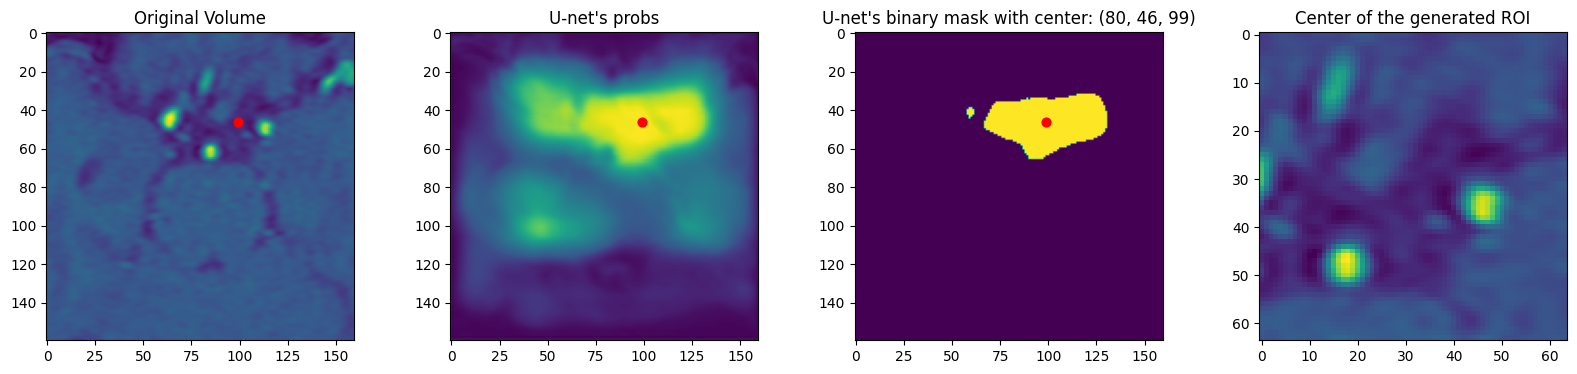

In [17]:
SERIES_EXAMPLE_NUMBER = df['SeriesInstanceUID'].iloc[4]
print(df.iloc[4])
SERIES_EXAMPLE = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
SERIES_EXAMPLE_FULL = SERIES_EXAMPLE + SERIES_EXAMPLE_NUMBER
predictions = predict(series_path= SERIES_EXAMPLE_FULL)
predictions  

## False Positive

SeriesInstanceUID                             1.2.826.0.1.3680043.8.498.10009383108068795488...
PatientAge                                                                                   71
PatientSex                                                                                 Male
Modality                                                                                    MRA
Left Infraclinoid Internal Carotid Artery                                                     0
Right Infraclinoid Internal Carotid Artery                                                    0
Left Supraclinoid Internal Carotid Artery                                                     0
Right Supraclinoid Internal Carotid Artery                                                    0
Left Middle Cerebral Artery                                                                   0
Right Middle Cerebral Artery                                                                  0
Anterior Communicating Artery           

,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,0.309957,0.354058,0.527678,0.533038,0.389572,0.436259,0.38886,0.148994,0.169781,0.222748,0.215718,0.253162,0.356814,0.553852


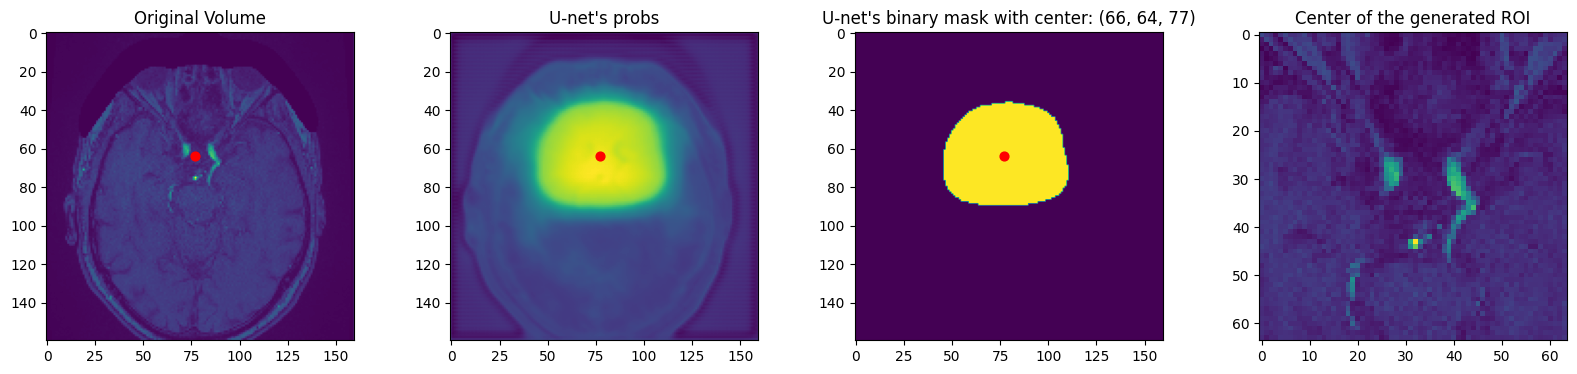

In [18]:
SERIES_EXAMPLE_NUMBER = df['SeriesInstanceUID'].iloc[3]
print(df.iloc[3])
SERIES_EXAMPLE = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
SERIES_EXAMPLE_FULL = SERIES_EXAMPLE + SERIES_EXAMPLE_NUMBER
predictions = predict(series_path= SERIES_EXAMPLE_FULL)
predictions  